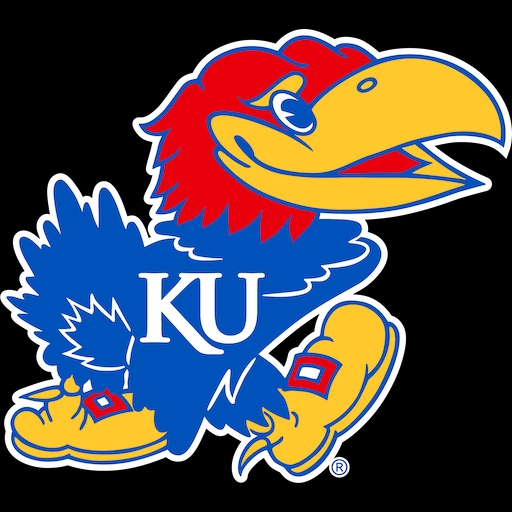

In [6]:
from pathlib import Path
from PIL import Image
import numpy as np
from sympy import Matrix

filename = Path("../img/color/Jayhawk_512x512.jpg")

with Image.open(filename, "r") as im:
    display(im)

# True for noisy execution, False for noiseless execution
noisy_execution = False
draw_qc = True

In [7]:
def display_quantum_circuit(qc):
    if draw_qc:
        display(qc.draw('mpl', reverse_bits=True))

In [8]:
from thesis.filters import *

stride = 1
num_layers = 2
fltr_raw = avg_filter(2, dim = 2)
fltr_raw1 = sobel_filter(4, axis=0)
# fltr_raw = laplacian()
# fltr_raw1 = gaussian_blur(2)

npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in fltr_raw.shape)
fltr = np.pad(fltr_raw, pad_width=npad, mode="constant", constant_values=0)

npad = tuple((0, 2 ** int(np.ceil(np.log2(N))) - N) for N in fltr_raw1.shape)
fltr1 = np.pad(fltr_raw1, pad_width=npad, mode="constant", constant_values=0)

Matrix(fltr)

Matrix([
[0.25, 0.25],
[0.25, 0.25]])

In [9]:
from thesis.quantum import flatten_image, normalize, wires_to_qubits, to_qubits
import pennylane as qml

psi, *dims = flatten_image(filename, pad=True)
psi, mag = normalize(psi, include_magnitude=True)

_, fltr_mag = normalize(fltr.flatten(order="F"), include_magnitude=True)
fltr /= fltr_mag

_, fltr_mag1 = normalize(fltr1.flatten(order="F"), include_magnitude=True)
fltr1 /= fltr_mag1

num_states = 2**sum(to_qubits(dims))
num_ancilla = sum(to_qubits(fltr.shape)) + sum(to_qubits(fltr1.shape))

(<Figure size 400x2500 with 1 Axes>, <Axes: >)

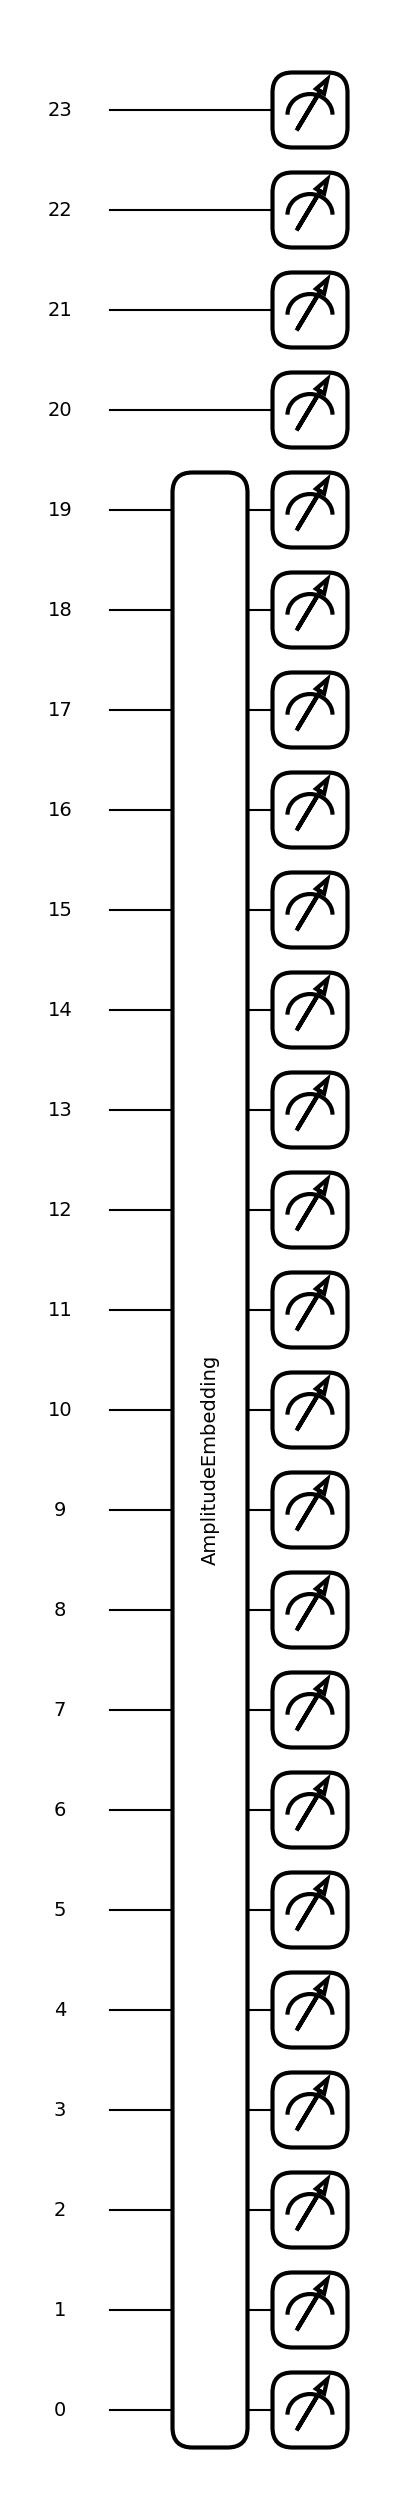

In [10]:
from pennylane.templates import AmplitudeEmbedding
from thesis.quantum.operation import Convolution
from thesis.quantum.operation.ansatz import ConvolutionAnsatz

ansatz = ConvolutionAnsatz.from_dims(dims)

qml.draw_mpl(ansatz.qnode)(psi)

In [11]:
psi_out = ansatz.qnode(psi_in=psi)

ValueError: value too large

In [ ]:
from thesis.quantum import construct_img

i = 0
img = psi_out.detach().numpy()[i*num_states:(i+1)*num_states]
norm = mag * fltr_mag * fltr_mag1 * np.sqrt(2**num_ancilla)
img = construct_img(norm*img, dims)
img.save("output.png")

display(img)

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

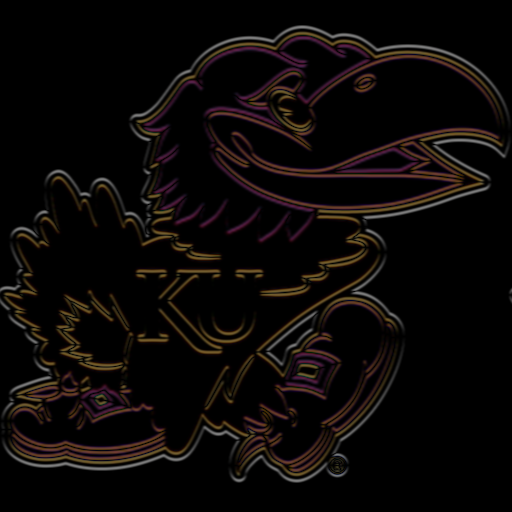

In [ ]:
from thesis.filters import convolution

with Image.open(filename, "r") as im:
    image_data = np.asarray(im, dtype=float)

image_data = convolution(image_data, fltr_raw)
classical_img = convolution(image_data, fltr_raw1)
classical_img = Image.fromarray(classical_img.astype(np.uint8))
display(classical_img)
classical_img.save("output_classical.png")

In [ ]:
from thesis.quantum import get_fidelity

fid = get_fidelity(np.asarray(classical_img).flatten(), np.asarray(img).flatten())

print(f"Fidelity: {fid:.03%}")

Fidelity: 0.265%
